In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data

Basic data cleaning includes deleting the puctuation marks in the titles, and convert text into lower case.

In [2]:
import string

titles = pd.read_csv("./data/medium_post_titles.csv")
titles.drop(columns=["subtitle", "subtitle_truncated_flag"], inplace=True)

titles.title = titles.title.str.replace('[{}]'.format(string.punctuation), '').str.lower()
titles.title = titles.title.str.replace('‘', '')
titles.title = titles.title.str.replace('’', '')
titles.title = titles.title.str.replace('“', '')
titles.title = titles.title.str.replace('”', '')
titles.title = titles.title.str.replace('—', '')

titles.head()

,category,title
0,work,21 conversations a fun and easy game for team...
1,spirituality,biblical porn at mars hill
2,lgbtqia,cisgender is that a disease
3,equality,call me nat love black cowboys and the frontie...
4,artificial-intelligence,can i train my model on your computer


Hold out 20% of data as the test set.

In [3]:
from sklearn.model_selection import train_test_split

titles_train, titles_test = train_test_split(titles, train_size=0.8, stratify=titles.category.values)

X_train = titles_train.title.values
X_test = titles_test.title.values

y_train = titles_train.category.values
y_test = titles_test.category.values

# Naive Bayess

Use TF-IDF to perform bag-of-words vectorization.

We adopted the Penn Treebank Tokenizer. Terms that appear less than twice or occur in more than 10% of the docuemnts are rejected. Typically, with TF-IDF vectorization, we can still use a multinomial naive Bayess classifier. Let's take a look at a naive Bayess classifer with Lapalace smoohing at alpha = 0.1. 

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

tokenizer = TreebankWordTokenizer()
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, ngram_range=(1, 1), stop_words='english', min_df=2, max_df=0.1)

NBclassifier = MultinomialNB(alpha=0.1)

classifier = Pipeline([("TfIdf", vectorizer), ("NaiveBayess", NBclassifier)])
classifier.fit(X_train, y_train)

accuracy = classifier.score(X_test, y_test)
print("accuracy = {}".format(accuracy))

accuracy = 0.35299003322259137


# Precision-recall

In [6]:
probability = classifier.predict_proba(X_test)
classList = classifier.classes_

In [7]:
realLabel = np.equal(np.repeat(np.reshape(y_test, (-1, 1)), len(classList), axis=1), np.repeat(np.reshape(classList, (1, -1)), len(y_test), axis=0))
thresholds = np.arange(0, 1.001, 0.001)
precision = np.zeros((len(thresholds), len(classList)))
recall = np.zeros((len(thresholds), len(classList)))

for i, threshold in enumerate(thresholds):
    predictedLabel = probability >= threshold

    truePoz = (predictedLabel & realLabel).sum(axis = 0)
    falsePoz = (predictedLabel & (realLabel == False)).sum(axis = 0)
    falseNeg = ((predictedLabel == False) & realLabel).sum(axis = 0)

    precision[i, :] = truePoz / (truePoz + falsePoz)
    recall[i, :] = truePoz / (truePoz + falseNeg)
    
averagePrecision = np.nanmean(precision, axis=1)
averageRecall = np.nanmean(recall, axis=1)
minPrecision = np.nanmin(precision, axis=1)
maxPrecision = np.nanmax(precision, axis=1)

Text(0, 0.5, 'precision')

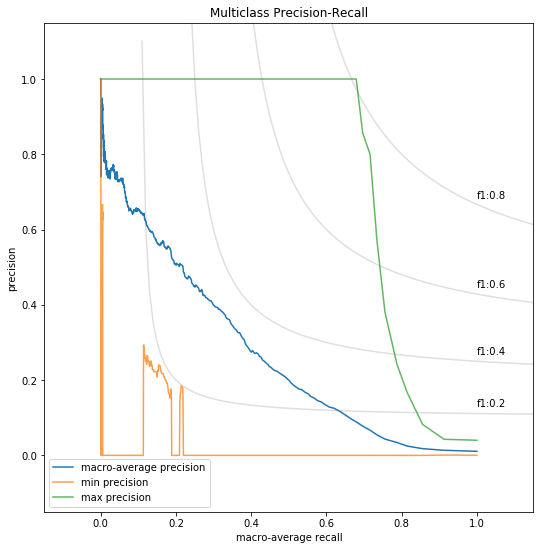

In [8]:
plt.figure(figsize=(9,9))

f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1.15, 115)
    y = f_score * x / (2 * x - f_score)
    plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.25)
    plt.annotate('f1:{0:0.1f}'.format(f_score), xy=(1, y[100] + 0.02))

plt.plot(averageRecall, averagePrecision, label="macro-average precision")
plt.plot(averageRecall, minPrecision, label="min precision", alpha=0.75)
plt.plot(averageRecall, maxPrecision, label="max precision", alpha=0.75)

plt.xlim([-.15, 1.15])
plt.ylim([-.15, 1.15])
plt.gca().set_aspect('equal')
plt.legend(loc="lower left")
plt.title("Multiclass Precision-Recall")
plt.xlabel("macro-average recall")
plt.ylabel("precision")

In [22]:
maxProbability = probability.max(axis=1)
classifiedProportion = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    classifiedProportion[i] = (maxProbability >= threshold).sum() / len(maxProbability)

Text(0.5, 1.0, 'Precision & Recall')

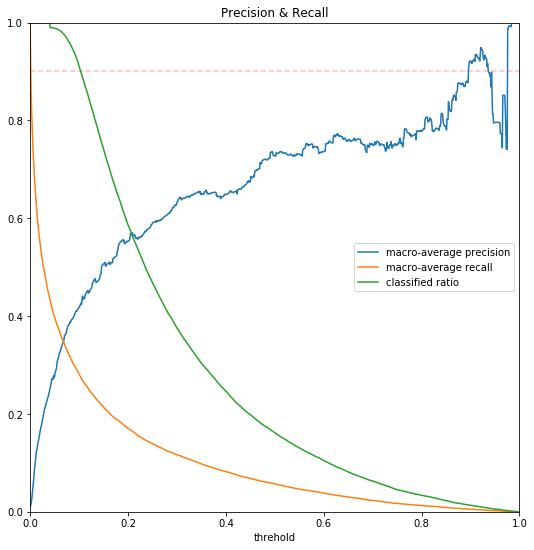

In [23]:
plt.figure(figsize=(9,9))

plt.axhline(0.9, color="red",linestyle='dashed', alpha=0.25)
plt.plot(thresholds, averagePrecision, label="macro-average precision")
plt.plot(thresholds, averageRecall, label="macro-average recall")
plt.plot(thresholds, classifiedProportion, label="classified ratio")

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal')
plt.legend(loc="center right")
plt.xlabel("threhold")
plt.title("Precision & Recall")

In [10]:
threshold90 = thresholds[averagePrecision >= 0.9].min()
recall90 = averageRecall[threshold90 == thresholds][0]
classified90 = classifiedProportion[threshold90 == thresholds][0]
print("To reach a multiclass average precision more than 90%, the minimum threshold is " + str(threshold90) + "; the corresponding multiclass average recall is " + str(recall90) + ".")

To reach a multiclass average precision more than 90%, the minimum threshold is 0.896; the corresponding multiclass average recall is 0.00552389969307397. 
